In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix
)

sns.set(style="whitegrid")


In [2]:
import pandas as pd

# Load dataset (Colab path)
df = pd.read_csv("/content/WA_Fn-UseC_-Telco-Customer-Churn.csv")

# Convert TotalCharges to numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(inplace=True)

# Encode target variable
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# Drop customer ID
df.drop(columns=['customerID'], inplace=True)

df.head()


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


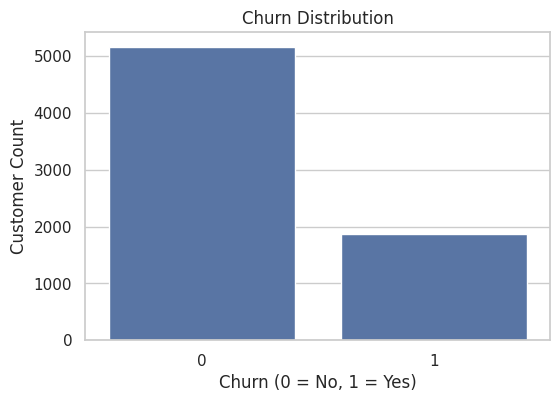

In [3]:
plt.figure(figsize=(6,4))
sns.countplot(x='Churn', data=df)
plt.title("Churn Distribution")
plt.xlabel("Churn (0 = No, 1 = Yes)")
plt.ylabel("Customer Count")
plt.show()


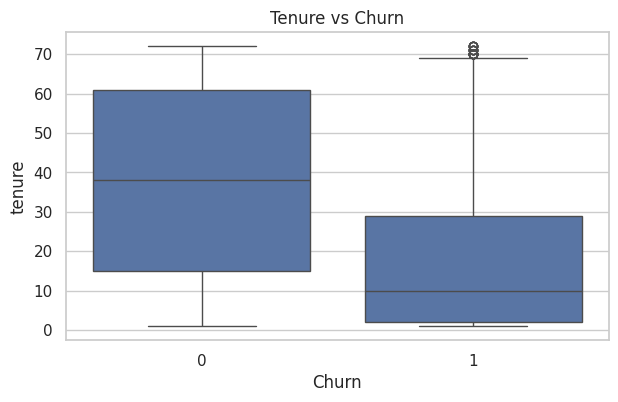

In [4]:
plt.figure(figsize=(7,4))
sns.boxplot(x='Churn', y='tenure', data=df)
plt.title("Tenure vs Churn")
plt.show()


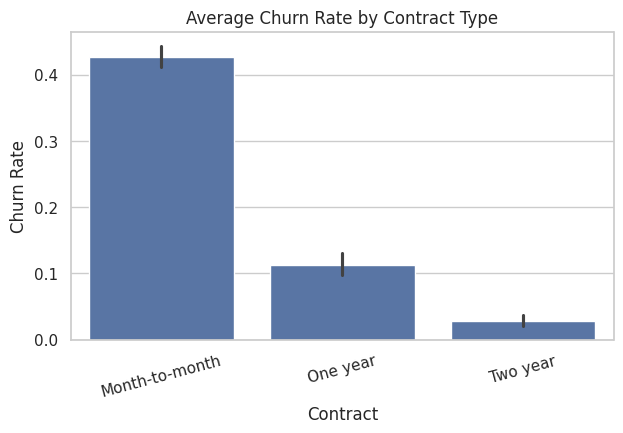

In [5]:
plt.figure(figsize=(7,4))
sns.barplot(
    x='Contract',
    y='Churn',
    data=df,
    estimator=np.mean
)
plt.title("Average Churn Rate by Contract Type")
plt.ylabel("Churn Rate")
plt.xticks(rotation=15)
plt.show()


In [6]:
categorical_cols = df.select_dtypes(include='object').columns
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

scaler = StandardScaler()
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
df_encoded[num_cols] = scaler.fit_transform(df_encoded[num_cols])


In [7]:
rfm = pd.DataFrame()
rfm['Recency'] = df['tenure']
rfm['Frequency'] = df['tenure']          # proxy
rfm['Monetary'] = df['MonthlyCharges'] * df['tenure']

rfm['R_Score'] = pd.qcut(rfm['Recency'], 4, labels=[4,3,2,1])
rfm['F_Score'] = pd.qcut(rfm['Frequency'], 4, labels=[1,2,3,4])
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 4, labels=[1,2,3,4])

rfm['RFM_Score'] = (
    rfm['R_Score'].astype(int) +
    rfm['F_Score'].astype(int) +
    rfm['M_Score'].astype(int)
)

def segment(score):
    if score >= 10:
        return 'Champions'
    elif score >= 7:
        return 'Potential Loyalists'
    else:
        return 'At Risk'

rfm['Segment'] = rfm['RFM_Score'].apply(segment)


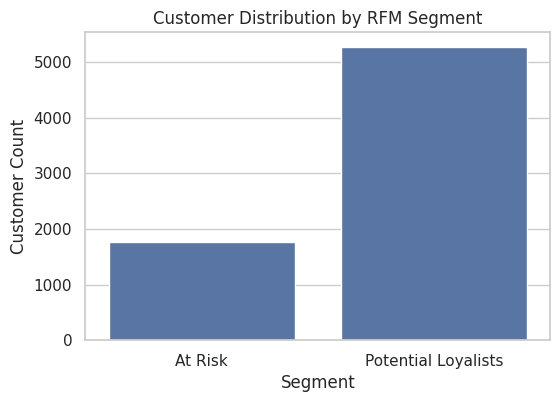

In [8]:
plt.figure(figsize=(6,4))
sns.countplot(x='Segment', data=rfm)
plt.title("Customer Distribution by RFM Segment")
plt.ylabel("Customer Count")
plt.show()


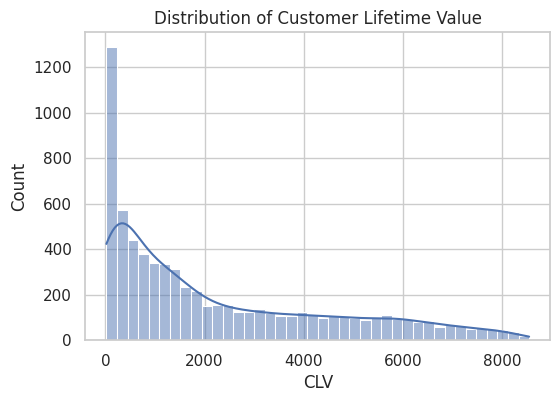

In [9]:
df_encoded['CLV'] = df['MonthlyCharges'] * df['tenure']

plt.figure(figsize=(6,4))
sns.histplot(df_encoded['CLV'], bins=40, kde=True)
plt.title("Distribution of Customer Lifetime Value")
plt.show()


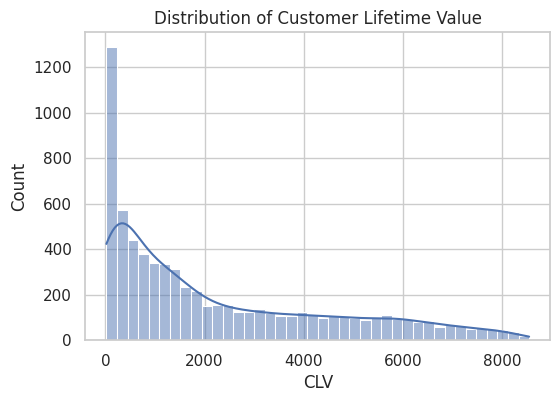

In [10]:
df_encoded['CLV'] = df['MonthlyCharges'] * df['tenure']

plt.figure(figsize=(6,4))
sns.histplot(df_encoded['CLV'], bins=40, kde=True)
plt.title("Distribution of Customer Lifetime Value")
plt.show()


In [11]:
X = df_encoded.drop(columns=['Churn'])
y = df_encoded['Churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [12]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [13]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)


In [14]:
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest'],
    'Accuracy': [
        accuracy_score(y_test, lr_preds),
        accuracy_score(y_test, rf_preds)
    ],
    'Precision': [
        precision_score(y_test, lr_preds),
        precision_score(y_test, rf_preds)
    ],
    'Recall': [
        recall_score(y_test, lr_preds),
        recall_score(y_test, rf_preds)
    ],
    'F1 Score': [
        f1_score(y_test, lr_preds),
        f1_score(y_test, rf_preds)
    ]
})

results


,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.802416,0.646341,0.566845,0.603989
1,Random Forest,0.791756,0.637288,0.502674,0.562033


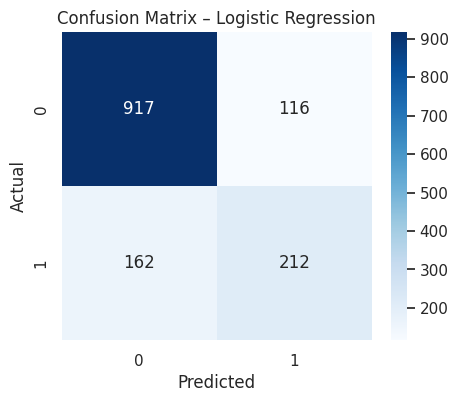

In [15]:
cm = confusion_matrix(y_test, lr_preds)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix – Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


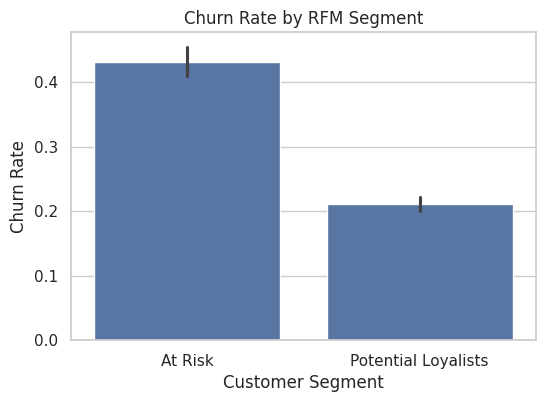

In [16]:
# Combine RFM segments with churn
rfm_churn = pd.concat(
    [rfm['Segment'], df['Churn']], axis=1
)

plt.figure(figsize=(6,4))
sns.barplot(
    x='Segment',
    y='Churn',
    data=rfm_churn,
    estimator=np.mean
)
plt.title("Churn Rate by RFM Segment")
plt.ylabel("Churn Rate")
plt.xlabel("Customer Segment")
plt.show()


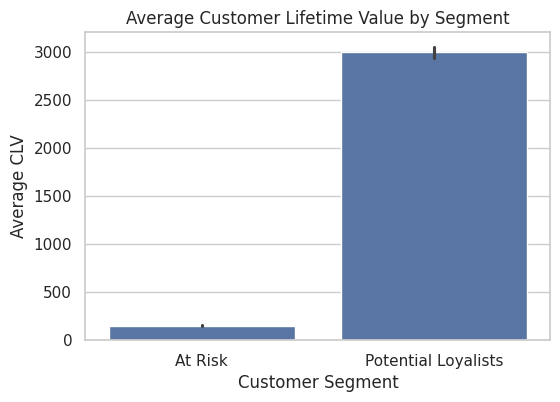

In [17]:
rfm_clv = pd.concat(
    [rfm['Segment'], df_encoded['CLV']], axis=1
)

plt.figure(figsize=(6,4))
sns.barplot(
    x='Segment',
    y='CLV',
    data=rfm_clv
)
plt.title("Average Customer Lifetime Value by Segment")
plt.ylabel("Average CLV")
plt.xlabel("Customer Segment")
plt.show()


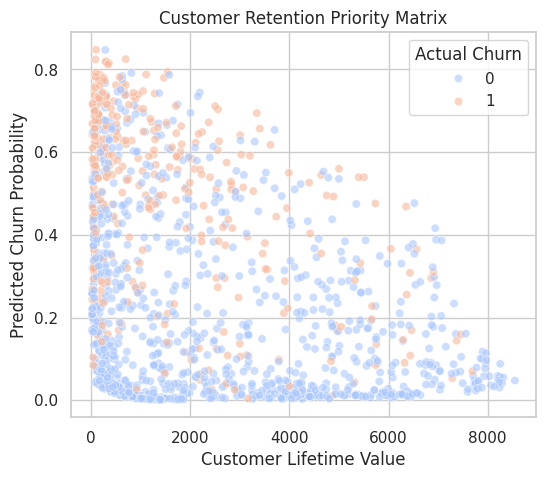

In [18]:
# Predict churn probability using Logistic Regression
df_encoded.loc[X_test.index, 'Churn_Prob'] = lr.predict_proba(X_test)[:,1]

plt.figure(figsize=(6,5))
sns.scatterplot(
    x=df_encoded.loc[X_test.index, 'CLV'],
    y=df_encoded.loc[X_test.index, 'Churn_Prob'],
    hue=y_test,
    palette='coolwarm',
    alpha=0.6
)
plt.xlabel("Customer Lifetime Value")
plt.ylabel("Predicted Churn Probability")
plt.title("Customer Retention Priority Matrix")
plt.legend(title="Actual Churn")
plt.show()


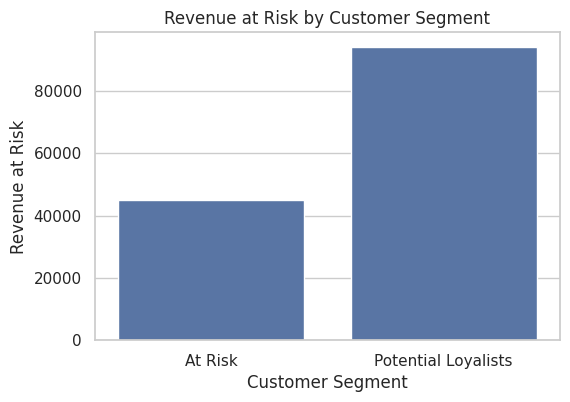

In [19]:
risk_df = df.copy()
risk_df['RevenueAtRisk'] = risk_df['MonthlyCharges'] * risk_df['Churn']
risk_df['Segment'] = rfm['Segment'].values

risk_segment = (
    risk_df
    .groupby('Segment')['RevenueAtRisk']
    .sum()
    .reset_index()
)

plt.figure(figsize=(6,4))
sns.barplot(
    x='Segment',
    y='RevenueAtRisk',
    data=risk_segment
)
plt.title("Revenue at Risk by Customer Segment")
plt.ylabel("Revenue at Risk")
plt.xlabel("Customer Segment")
plt.show()


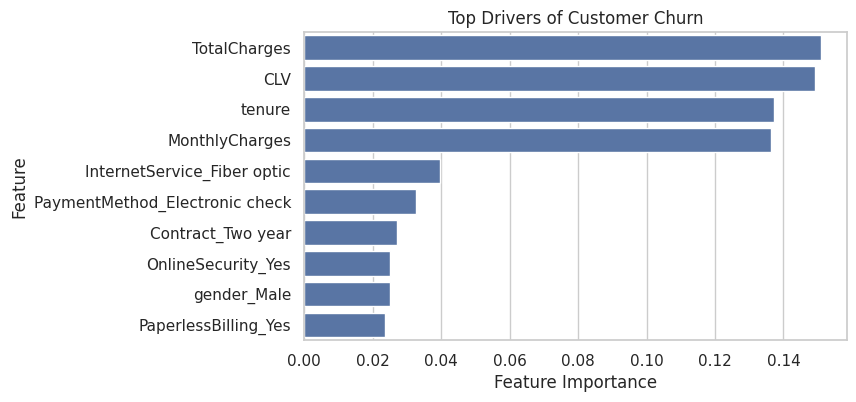

In [20]:
importances = rf.feature_importances_
features = X.columns

fi = (
    pd.DataFrame({
        'Feature': features,
        'Importance': importances
    })
    .sort_values(by='Importance', ascending=False)
    .head(10)
)

plt.figure(figsize=(7,4))
sns.barplot(
    x='Importance',
    y='Feature',
    data=fi
)
plt.title("Top Drivers of Customer Churn")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.show()


In [21]:
results_df = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest"],
    "Accuracy": [accuracy_score(y_test, lr_preds), accuracy_score(y_test, rf_preds)],
    "Precision": [precision_score(y_test, lr_preds), precision_score(y_test, rf_preds)],
    "Recall": [recall_score(y_test, lr_preds), recall_score(y_test, rf_preds)],
    "F1-Score": [f1_score(y_test, lr_preds), f1_score(y_test, rf_preds)]
})

results_df


,Model,Accuracy,Precision,Recall,F1-Score
0,Logistic Regression,0.802416,0.646341,0.566845,0.603989
1,Random Forest,0.791756,0.637288,0.502674,0.562033


In [22]:
test_df = df_encoded.loc[X_test.index].copy()

test_df['Churn_Prob'] = lr.predict_proba(X_test)[:, 1]
high_risk_customers = (
    test_df
    .sort_values(by='Churn_Prob', ascending=False)
    .head(10)[['tenure', 'MonthlyCharges', 'CLV', 'Churn_Prob']]
)

high_risk_customers


,tenure,MonthlyCharges,CLV,Churn_Prob
3380,-1.280248,1.007245,95.10,0.847703
3159,-1.198760,0.998935,284.55,0.847387
2631,-1.035784,1.145193,694.75,0.825037
4585,-1.280248,0.673179,85.05,0.824317
3727,-1.198760,1.057106,289.80,0.819047
2797,-1.198760,1.201702,302.85,0.818490
582,-1.158016,0.811126,356.80,0.815749
933,-1.158016,0.658220,338.40,0.811937
2516,-0.669089,1.050458,1542.40,0.794269
6240,-1.280248,0.947412,93.30,0.792583


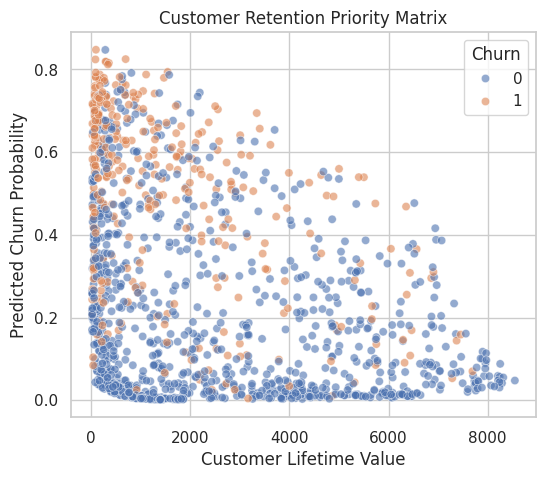

In [23]:
plt.figure(figsize=(6,5))
sns.scatterplot(
    x=test_df['CLV'],
    y=test_df['Churn_Prob'],
    hue=y_test,
    alpha=0.6
)
plt.xlabel("Customer Lifetime Value")
plt.ylabel("Predicted Churn Probability")
plt.title("Customer Retention Priority Matrix")
plt.show()


In [24]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(
    LogisticRegression(max_iter=1000),
    X, y, cv=5, scoring='f1'
)

print("Mean F1-score (5-fold CV):", cv_scores.mean())


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Mean F1-score (5-fold CV): 0.599998568103502


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


This project demonstrates an end-to-end predictive customer analytics pipeline, integrating data preprocessing, behavioral segmentation, CLV estimation, and churn prediction. The analysis provides actionable insights for targeted retention strategies and efficient marketing resource allocation.